In [1]:
import numpy as np
import librosa
import IPython.display as ipd
import random
import scipy.stats as st
import scipy.special as ss

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
y, sr = librosa.load('audio/NickDrake_8k.wav')
z, _= librosa.load('audio/Loureed_8k.wav')
w, _= librosa.load('audio/tom1_8k.wav')

In [3]:
T = len(y)

Gerando a matriz S das fontes

In [4]:
S = np.array([z,w,y])

Gerando a Matriz A

In [5]:
theta = np.array([np.pi/2, np.pi-np.pi/8, np.pi/8])/2
A = np.array([np.sin(theta), np.cos(theta)])


Gerando Ruido N

In [6]:
m , n = A.shape
sigma = 0.01
N = st.norm.rvs(loc = 0, scale = sigma, size = (m,T) )

In [7]:
X  = np.dot(A,S) + N
X.shape

(2, 180634)

In [8]:
ipd.Audio(X[0],rate = sr)

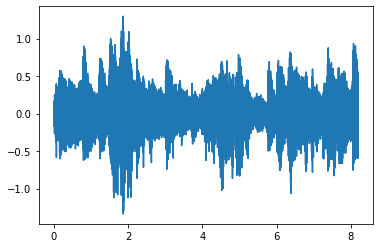

In [102]:
sns.lineplot(np.arange(0,len(y)/sr,1/sr),X[0])

Compunting the DCT

In [9]:
from scipy.fftpack import dct, idct

CX = dct(X, norm = 'ortho')

In [66]:
CX.shape

(2, 180634)

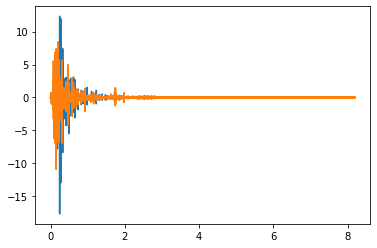

In [113]:
sns.lineplot(np.arange(0,len(y)/sr,1/sr),CX[0])
sns.lineplot(np.arange(0,len(y)/sr,1/sr),CX[1])

In [12]:



#%%% Priors %%%

#% Inverse-Gamma prior on sigma_sqrd
shape_sigma_sqrd_prior = 0
scale_sigma_sqrd_prior = 0

#% Gamma prior on beta
shape_beta_prior = np.zeros((n,1))
scale_beta_prior = np.zeros((n,1))

#% Exponential prior on alpha
scale_alpha_prior = np.ones((n,1))

#%% Gaussian prior on the columns of A
#%sigma_A = 100 * ones(n,1)

#%%% Initializations %%%
cur_A = np.array([[1, 1, 1],[0, 0, 0]])

#% Variance of the noise initialisation
#%cur_sigma_sqrd=(sigma)^2
cur_sigma_sqrd=0.1

#% Sources scale parameter initialisation
cur_beta=1*np.ones((n,1))
#%cur_beta = beta

cur_alpha = 0.5*np.ones((n,1))
#%cur_alpha = alpha

#% Sources coefficients initialisation
cur_CS= np.dot(np.linalg.pinv(cur_A),CX)
#%cur_CS=ones(n,T);

#%cur_ivarCS=cur_CS.^-2;
cur_ivarCS=np.ones((n,T))


In [13]:
#%%% Definitions %%%
n_iter = 1000
n_newton_iter = 100
store_A=np.zeros((m,n,n_iter))
store_A[:,:,1]=cur_A
store_sigma_sqrd=np.zeros((n_iter)) 
store_sigma_sqrd[0]=cur_sigma_sqrd

store_alpha=np.zeros((n,n_iter)) 
store_alpha[:,1]=cur_alpha.T
store_beta=np.zeros((n,n_iter)) 
store_beta[:,1]=cur_beta.T


store_CS=np.zeros((n,T,n_iter))
store_CS[:,:,1]=cur_CS
store_ivarCS=np.zeros((n,T,n_iter)) 
store_ivarCS[:,:,1]=cur_ivarCS




In [14]:
import numpy.matlib

In [104]:
#%%% Gibbs sampler %%%
for it in range(1,n_iter):
    #waitbar(iter/n_iter);
    
    #%%% Component by component update %%%
    for i in range(1,n):
        
        #% Update beta(i) %
        F=1
        shape_betai_post = cur_alpha[i]*T + shape_beta_prior[i]
        scale_betai_post = np.sum(np.multiply(F,cur_ivarCS[i,:])) + scale_beta_prior[i] #%% F %%
        cur_beta[i] = st.gamma.rvs(a = shape_betai_post, scale = 1/scale_betai_post)    #cf_gamrnd    #lambda
        
        # era para ser uma gamma com parametros a = alpha_i*N/2 e scale = 2/(alpha_i*R_i)
        
        #print('#'*40)
        #print('shape_betai_post = ',shape_betai_post)
        #print('scale_betai_post',scale_betai_post)
        #print("cur_beta[{}]".format(i),cur_beta[i])
        
        #% Update alpha(i) using MH%
            #if switch_alpha_MH
        scale_alphai_post = np.log(cur_beta[i]) + np.sum(np.log(cur_ivarCS[i,:]))/T - scale_alpha_prior[i]/T
        mode_alphai = cur_alpha[i]
        
        for l in range(1,n_newton_iter):
            mode_alphai = mode_alphai - (ss.psi(mode_alphai)-scale_alphai_post)/ss.polygamma(1,mode_alphai)
        
        
        inflex_alphai = 2 * mode_alphai #% Init
        for l in range(1,n_newton_iter):
            inflex_alphai = inflex_alphai - (ss.polygamma(1,inflex_alphai)-(ss.psi(inflex_alphai)-scale_alphai_post)**2)/(ss.polygamma(2,inflex_alphai)-2*ss.polygamma(1,inflex_alphai)*(ss.psi(inflex_alphai)-scale_alphai_post))
                
        alphai_instr = T*mode_alphai**2/(mode_alphai-inflex_alphai)**2 + 1
        betai_instr = T*mode_alphai/(mode_alphai-inflex_alphai)**2
        #print('alphai_instr =',alphai_instr)
        #print('betai_instr = ',betai_instr)
        #print(it,i)
        #print("scale_alphai_post = ",scale_alphai_post)
        alphai_star = st.gamma.rvs(a = alphai_instr, scale = 1/betai_instr)
                
        log_accept_ratio = T*(np.log(ss.gamma(cur_alpha[i]))-np.log(ss.gamma(alphai_star))+(alphai_instr-1)*(np.log(cur_alpha[i])-np.log(alphai_star))
                    + (scale_alphai_post+betai_instr)*(alphai_star-cur_alpha[i]))

        if np.log(np.random.rand()) <= log_accept_ratio:
            cur_alpha[i] = alphai_star
            
        else:
            cur_alpha[i] = mode_alphai
            
            
        
        
        
        
        #% Update ivarCS(i,:) %
        shape_ivarcsi_post = np.matlib.repmat(cur_alpha[i] + 1/2,1,T)
        scale_ivarcsi_post = np.power(cur_CS[i,:],2)/2 + cur_beta[i]*F #%% F %%
        cur_ivarCS[i,:] = st.gamma.rvs(a = shape_ivarcsi_post,scale = 1/scale_ivarcsi_post)  #cf_gamrnd
        
      
 ############################################################# 
        index = list(range(1,n)) 
        index.pop(i-1)
        Y_i = CX - cur_A[:,index]*cur_CS[index,:]
        
        
        #update A 
        var_ai = cur_sigma_sqrd*np.sum(np.power(cur_CS[i,:],2))
        mu_ai = np.multiply(var_ai,(np.dot(Y_i,cur_CS[i,:].T))/cur_sigma_sqrd)
        #print('mu_ai = ',mu_ai)
        
        
        cur_A[:,i] = np.sqrt(var_ai)*st.norm.rvs(size = (m)) + mu_ai 
        
        
        # a) Removes scale and sign indeterminacy
        # Norm 2 normalization
        #print('cur_A**2',np.sum(np.power(cur_A[:,i],2)))
        #print(cur_A[:,i].shape)
        #print(cur_A[:,i])
        cur_A[:,i] = cur_A[:,i]/np.sum(abs(cur_A[:,i]))
        # b) Set cur_A(1,i) = 1
           
         #% Update sigma_sqrd %
        
        shape_sigma_sqrd_post = (T*m/2 + shape_sigma_sqrd_prior)
      
        
        scale_sigma_sqrd_post = np.linalg.norm(CX-np.dot(cur_A,cur_CS),'fro')**2/2 + scale_sigma_sqrd_prior
        cur_sigma_sqrd = st.gamma.rvs(a = shape_sigma_sqrd_post,scale = 1/scale_sigma_sqrd_post)
        
                               
    
            
                            


In [78]:
      
                               
    store_CS[:,:,it]=cur_CS
    store_ivarCS[:,:,it]=cur_ivarCS

    store_A[:,:,it]=cur_A
    store_sigma_sqrd[it]=cur_sigma_sqrd
    store_alpha[:,it]=cur_alpha.Tb
    store_beta[:,it]=cur_beta.T
 

array([  0,   1,   8,  27,  64, 125], dtype=int32)

In [106]:
cur_A


array([[1, 0, 0],
       [0, 0, 0]])

In [92]:
www = np.array([-3, -5])

In [93]:
abs(www)

array([3, 5])

In [104]:
(np.sqrt(var_ai)*st.norm.rvs(size = (m,1)) + mu_ai).shape
cur_CS.shape

(3, 180634)

In [107]:
np.linalg.norm(CX-np.dot(cur_A,cur_CS),'fro')**2/2

3687.960119306773

In [37]:
T*mode_alphai**2/(mode_alphai-inflex_alphai)**2 + 1


array([4.89714779e+10])

In [81]:
a = np.matrix([[1,-1],[2,-1]])
a
b = np.array([[6],[4]])
b,a

(array([[6],
        [4]]),
 matrix([[ 1, -1],
         [ 2, -1]]))

In [88]:

B_1 = np.linalg.inv(a)
b = np.array([[6],[4]])
B_1*b

matrix([[-2.],
        [-8.]])

In [85]:
c = np.array([1,-2])
c*B_1*b

matrix([[-1.]])

In [38]:
c*B_1*np.array([[0],[1]])

matrix([[1.]])

In [48]:
B_1*np.array([[0],[1]])

matrix([[1.],
        [0.]])